In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import datagenerators as dg

In this section, I will be using the excellent [`CausalInference`](http://causalinferenceinpython.org/) package to give an overview of how we can use the [potential outcomes](https://en.wikipedia.org/wiki/Rubin_causal_model) framework to try and make causal inferences about situations where we only have observational data. The author has a good series of [blog posts](http://laurence-wong.com/software/) on it's functionality.

Because most datasets you can down are static, throughout this post I will be using be using my own functions to generate data. This has two advantages: we can and will generate datasets with specific properties, and we have the ability to "intervene" in the system directly, so we can directly measure the impact of the intervention.

You can the functions which generate these datasets in the accompanying file `datagenerators.py`.

To begin, let's look at a motivating example.

# Introduction

One day a team lead notices that some members of their team wear cool hats, and that these members of the team tend to be less productive. Being data drive, the Team Lead starts to record whether or not a team member wears a cool hat ($X=1$ for a cool hat, $X=0$ for no cool hat) and whether or not they are productive ($Y=1$ for productive, $Y=0$ for unproductive).

After making observations for a week, they end up with a dataset like the following:

In [2]:
observed_data_0 = dg.generate_dataset_0()

observed_data_0.head()

,x,y
0,1,1
1,0,0
2,1,1
3,1,0
4,1,1


The first question the team lead asks is: are people wearing cool hats more likely to be productive? This means estimating the quantity

$P(Y=1|X)$

which we can do directly from the data:

In [3]:
def estimate_uplift(ds):
    """Estiamte the difference in means between two groups"""
    base = ds[ds.x == 0]
    variant = ds[ds.x == 1]
    
    delta = variant.y.mean() - base.y.mean()
    delta_std = 1.96 * np.sqrt(
        variant.y.var() / variant.shape[0] + 
        base.y.var() / base.shape[0])
    
    return {"estimated_effect": delta, "standard_error": delta_std}

estimate_uplift(observed_data_0)

{'estimated_effect': -0.077491837910505068,
 'standard_error': 0.087182800430597604}

It looks like people with cool hats are less productive. 

To be sure, we can even run a statistical test:

In [4]:
from scipy.stats import chi2_contingency

contingency_table = (
    observed_data_0
    .assign(placeholder=1)
    .pivot_table(index="x", columns="y", values="placeholder", aggfunc="sum")
    .values
)

_, p, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")

# p-value
p

0.098740660328868052

That's one small p-value. [Statistians would be proud](https://www.nature.com/articles/s41562-017-0189-z).

Our team lead now decides that this is enough evidence to require everyone to wear really cool hats, but being good data scientists, we stop them and say no - let's run a [randomized control trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial). Specifically, we want to randomize who gets cool hats and who doesn't, and look at the effect. 

Because we generated our dataset from a known process (in this case a function I wrote), we can intervene in it directly and measure the effect of an A/B test:

In [5]:
def run_ab_test(datagenerator, n_samples=10000, filter_=None):
    """Generates n_samples from datagenerator with the value of X randomized
    """
    n_samples_a = int(n_samples / 2)
    n_samples_b = n_samples - n_samples_a
    set_X = np.concatenate([np.ones(n_samples_a), np.zeros(n_samples_b)]).astype(np.int64)
    ds = datagenerator(n_samples=n_samples, set_X=set_X)
    if filter_ != None:
        ds = ds[filter_(ds)].copy()
    return estimate_uplift(ds)

run_ab_test(dg.generate_dataset_0)

{'estimated_effect': 0.19920000000000004,
 'standard_error': 0.019208192837599721}

Suddenly, it looks like the direction of the effect of wearing cool hats has reversed. 

What's going on?

# Definitions of Causality 

The previous example shows the old statistics saying: 

[**Correlation Does Not Imply Causation**](https://xkcd.com/552/).

["Causality"](https://plato.stanford.edu/entries/causation-metaphysics/) is a vague, philosophical sounding word, so to be precise, when I talk about causality in the following, I am talking about how the distribution of one random variable changes when we force another random variable to take a certain value. I will call the act of forcing a variable to take a certain value an Intervention.

In the previous example, when we make no intervention on the system, we have an observational distribution of $Y$, conditioned on the fact we observe $X$:

$P(Y|X)$

When we force people to wear cool hats, we are making an intervention. The distribution of $Y$ is then given by the _interventional_ distribution 

$P(Y|\hbox{do}(X))$

In general these two are not the same.

The question these notes will try and answer is how we can reason about the interventional distribution, when we only have access to observational data.

# Potential Outcomes 

One way to approach this problem is to introduce two new random variables to our system: $Y_{0}$ and $Y_{1}$, known as the [Potential Outcomes](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf). We imagine that these variables exist, and can be treated as any other random variable - the only difference is that they are never directly observed. $Y$ is defined in terms of 

 - $Y = Y_{1}$ when $X=1$
 - $Y = Y_{0}$ when $X=0$
 
This shifts the problem from one about how distributions change under the intervention, to one about data drawn i.i.d. from some underlying distribution with [missing values](https://en.wikipedia.org/wiki/Missing_data). Under certain assumptions about why values are missing, there is well developed theory about how to estimate the missing values.

# Goals

Often we do not care about the full interventional distribution, $P(Y|\hbox{do}(X))$, and it is enough to have an estimate of the difference in means between the two groups. This is a quantity known as the [Average Treatment Effect](https://en.wikipedia.org/wiki/Average_treatment_effect):

$\Delta = E[Y_{1} - Y_{0}]$

When we run and A/B test and compare the means of each group, this is directly the quantity we are measuring 

If we just try and estimate this quantity from the observational distribution, we get:

$\Delta_{bad} = E[Y|X=1] - E[Y|X=0] \\
= E[Y_{1}|X=1] - E[Y_{0}|X=0] \\
\neq \Delta$

This is not generally equal to the true ATE because:

$E[Y_{1}|X=1] \neq E[Y_{1}]$

$\def\ci{\perp\!\!\!\perp}$
# Making Assumptions

When we A/B test, we randomize the assignment of $X$. This has the effect of allowing us to choose which variable of $Y_{1}$ or $Y_{0}$ is revealed to us. This makes the outcome independent of $X$. We write this as

$Y_{1}, Y_{0} \ci X$

Which means that the distribution of $X, Y_{0}, Y_{1}$ factorizes as

$P(X, Y_{0}, Y_{1}) = P(X)P(Y_{0}, Y_{1})$

If this independence holds then

$E[Y_{1}|X=1] = E[Y_{1}]$

If we want to estimate the ATE using observational data, we need to use other information we have about the samples - specifically we need to **assume** that we have enough additional information to completely explain the choice of treatment each subject.

If we call the additional information the random variable $Z$, we can write this assumption as

$Y_{1}, Y_{0} \ci X | Z$

or

$P(X, Y_{0}, Y_{1}| Z) = P(X|Z)P(Y_{0}, Y_{1}|Z)$

The quality of any prediction you make depends on exactly how much you trust this assumption. [Simpson's Paradox](http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/) is an extreme example of the fact that if $Z$ does not give contain all confound variables, then any inference we make could be wrong. [Facebook have a good paper comparing different causal inference approaches with direct A/B test that show how effects can be overestimated when conditional independence doesn't hold](https://www.kellogg.northwestern.edu/faculty/gordon_b/files/kellogg_fb_whitepaper.pdf).

Once we have made this assumption there are a number of techniques for approaching this. I will outline a few of simpler approaches in the rest of the post, but keep in mind that this is a area of ongoing research.

# Modeling the Counterfactual

From the above, it should be clear that if know $Y_{0}$ and $Y_{1}$, we can estimate the ATE. So why not just try and model them directly? Specifically we can build estimators: 
 
 - $\hat{Y}_{0}(Z) = E[Y|Z, X=0]$
 - $\hat{Y}_{1}(Z) = E[Y|Z, X=1]$. 
 
If we can model these two quantities, we can estimate the ATE as:

$\Delta = \frac{1}{N}\sum_{i}(\hat{Y}_{1}(z_{i}) - \hat{Y}_{0}(z_{i}))$

The success of this approach depends on how well we can model the potential outcomes. To see it in action, let's use the following data generating process:

Observed ATE: 0.177 (0.097)
Real ATE:  -0.494 (0.025)


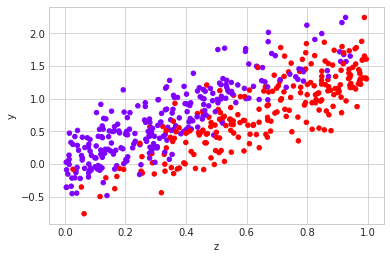

In [6]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

The simplest type of model we can use is a linear model. Specifically we could assume 

$Y_{0} = \alpha + \beta Z + \epsilon$

$Y_{1} = Y_{0} + \gamma$

If this is accurate, fitting the model

$Y = \alpha + \beta Z + \gamma X$

to the data using linear regression will give us an estimate of the ATE.

The `causalinference` package gives us a simple interface to do this:

In [7]:
from causalinference import CausalModel

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.478      0.031    -15.286      0.000     -0.539     -0.416
           ATC     -0.455      0.036    -12.750      0.000     -0.524     -0.385
           ATT     -0.503      0.036    -13.901      0.000     -0.574     -0.432



The package has done will in identifying the correct ATE - which is good, but the data generating process was specifically designed to meet the assumptions. Let's look at a few cases where it might fail.

This first is when the effect is not simply additive:

Observed ATE: 0.781 (0.109)
Real ATE:  0.568 (0.030)


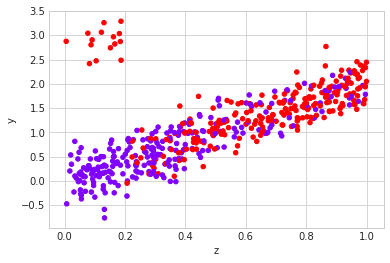

In [8]:
observed_data_2 = dg.generate_dataset_2()

observed_data_2.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_2)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_2)))

In [9]:
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.378      0.074      5.086      0.000      0.232      0.524
           ATC      0.569      0.110      5.199      0.000      0.355      0.784
           ATT      0.185      0.046      4.019      0.000      0.095      0.276



Usually this can be overcome by using more powerful estimators . A simple, non-parametric approach, is the technique of [matching](https://en.wikipedia.org/wiki/Matching_%28statistics%29). The idea is to find for each sample which received the treatment, a similar samples which did not receive the treatment, and to directly compare these values. Exactly what you mean by "similar" will depend on your specific usecase., 

The package `causalinference` implements matching by selecting for each unit, with replacement, the most similar unit from the other treatment group and using the difference between these two units to calculate the ATE. By default, the choice of match is chosen to be the nearest neighbour in covariate space $Z$, with the distances weighted by inverse variance of each dimension.

There are options to change the number of units compared and the weighting of each dimension in the match. For more details, see the [documentation](http://laurence-wong.com/software/matching).

We can compute the matching estimate with the following code

In [10]:
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.554      0.135      4.091      0.000      0.289      0.819
           ATC      0.911      0.139      6.576      0.000      0.639      1.182
           ATT      0.194      0.187      1.039      0.299     -0.172      0.560



The confidence intervals around our estimate now contain the true ATE.

# Covariate Imbalance

A more difficult problem to deal with is when the covariates you are using are imbalanced: when there are areas of covariate space which contains only the treated or untreated samples. Here we have to extrapolate the effect of the treatment - which will depend heavily on assumptions model we use. 

The example below demonstrates this:

Observed ATE: 1.403 (0.077)
Real ATE:  2.452 (0.034)


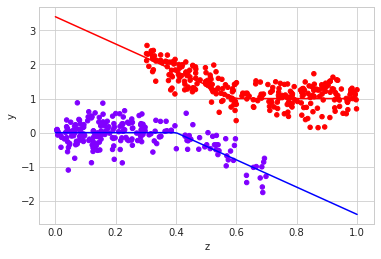

In [11]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

In [12]:
# OLS estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.944      0.057     34.177      0.000      1.832      2.055
           ATC      2.025      0.053     38.451      0.000      1.922      2.129
           ATT      1.877      0.082     22.984      0.000      1.717      2.038



In [13]:
# Matching estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.140      0.193     11.115      0.000      1.762      2.517
           ATC      2.211      0.345      6.412      0.000      1.535      2.887
           ATT      2.082      0.202     10.304      0.000      1.686      2.478



The OLS estimator fails to capture the true effect, and while the matching estimator improves things a bit, there just isn't enough information in the data to extrapolate fully into areas where there isn't overlap.

This example might seem contrived - that's because it is, but once we start looking covariates with higher dimensionality this issue can become much more common.

`CausalInference` provides a useful tool to quickly assess the overlap of the variables using the `summary_stats` property:

In [14]:
print(cm.summary_stats)


Summary Statistics

                       Controls (N_c=224)         Treated (N_t=276)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -0.104        0.419        1.299        0.463        1.403

                       Controls (N_c=224)         Treated (N_t=276)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.241        0.180        0.660        0.209        2.150



# Propensity Score

The Propensity score is a estimate of how likely it is for a subject to have ended up with the treatment, given the covariates:

$\hat{p}(Z) = P(X|Z)$

We can estimate this however we like, but once we have it there are a number of things we can do with it.


## Inverse Propensity Score Weighting

Remember that the problem of measuring causal inference is that we want to know the quantity $E[Y_{i}]$, but we only have access to samples from $E[Y_{i}|X=i]$.

The probability of a potential outcome can be expanded to give

$P(Y_{i}) = P(Y_{i}| X = i)P(X = i)$

This suggests that we can estimate the true 

$E[Y_{i}] = E[\frac{Y_{i}}{P(X=i|Z)}P(X=i|Z)] = E[\frac{Y_{i}}{P(X=i|Z)}|X=i, Z]$

So if we weight each point by it's inverse propensity, we can recover the potential outcomes. The result is the [inverse propensity score weight estimator](https://en.wikipedia.org/wiki/Inverse_probability_weighting):

$\Delta_{IPS} = \frac{1}{N}\left(\sum_{i \in 1} \frac{y_{i}}{\hat{p}(z_{i})} - \sum_{i \in 0} \frac{y_{i}}{1 - \hat{p}(z_{i})}\right)$

Let's see how it does one of our previous datasets:

Observed ATE: 0.062 (0.100)
Real ATE:  -0.507 (0.025)


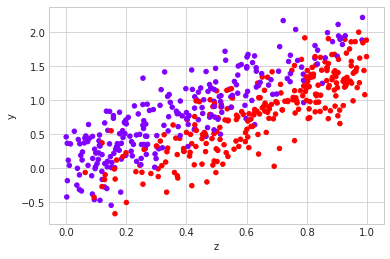

In [15]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

We can estimate the propensity using the `CausalInference` package's methods `est_propensity_s` or `est_propensity`, which use a linear estimator to estimate propensity:

In [16]:
cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()

propensity = cm.propensity["fitted"]

df = observed_data_1

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.49638451630944563

This does well in our situation - by is very dependent on how good our estimate of the propensity score is - for the data generator we're using for this example, the relationship is linear. If we tried to estimate the propensity using, say, logistic regression we would have got the wrong answer:

In [17]:

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
X = df.z.values.reshape(-1,1)
y = df.x.values
lg.fit(X,y)

propensity = lg.predict_proba(X)[:,1]

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.37945047729417947

It does better than our naive estimator, but is not correct.

# Doubly Robust Weighted Estimator

We can combine the inverse propensity score weighting estimators and the linear estimator of effect size together to try and reduce the flaws in either model. This is done by preforming weighted linear regression on the data, with each point weighted by the inverse propensity score. The result is the [doubly robust weighted estimator](https://academic.oup.com/aje/article/173/7/761/103691). We can apply it using the following:

Observed ATE: 0.172 (0.098)
Real ATE:  -0.500 (0.025)


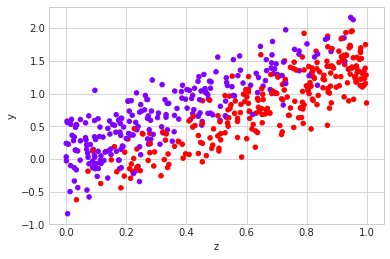

In [18]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

In [19]:
cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.461      0.029    -15.715      0.000     -0.519     -0.404



# Unconfoundedness and the Propensity Score 

In the previous sections, we assumed that the outcomes and the treatment were independent given our covariates:

$Y_{1}, Y_{0} \ci X \, | \,Z$

We can also assume something slightly stronger: that the outcomes are independent of the treatment, conditioned on the probability of the propensity:

$Y_{1}, Y_{0} \ci X \, | \,\hat{p}(Z)$

With this assumption, we potentially reduce the dimensionality of the confounding variables. This allows us to perform several techniques which may not work in higher dimensional settings. 

# Trimming

We previously saw that imbalances in covariates can create issues. A simple solution is to only make predictions for the counterfactual in regions where there is a good overlap, or "trim" points where there is not good overlap. For high dimensional data "good overlap" can be difficult to define - using just the propensity score to define overlap is one way to solve this. 

Let's look at a dataset with low overlap:

Observed ATE: 1.286 (0.082)
Real ATE:  2.421 (0.033)


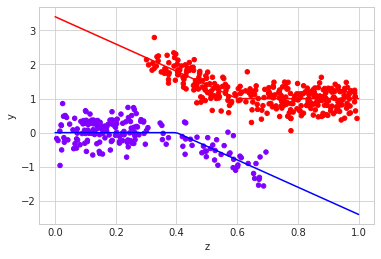

In [20]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

`CausalInference` offers a method to trim the data based on the propensity score

In [21]:
# OLS estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_propensity_s()
cm.trim_s()
cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.908      0.100     19.084      0.000      1.712      2.104
           ATC      1.967      0.193     10.216      0.000      1.589      2.344
           ATT      1.868      0.083     22.392      0.000      1.704      2.031



We can look at the remaining data in the following way

Observed ATE: 1.665 (0.120)
Real ATE:  2.006 (0.031)


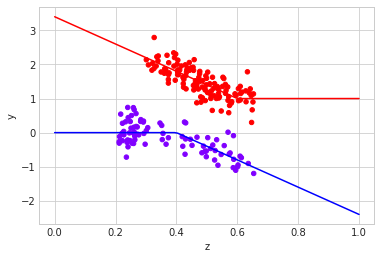

In [22]:
# mask out data ignored by the 
propensity = cm.propensity["fitted"]
cutoff = cm.cutoff
mask = (propensity > cutoff) &  (propensity < 1 - cutoff)

# plot the data
observed_data_3[mask].plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")

# filter out data in regions we have trimmed when we calculate the true uplift
filter_ = lambda df: (df.z > 0.2) & (df.z < 0.7)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3[mask])))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(
    **run_ab_test(dg.generate_dataset_3, filter_= filter_)))

# Stratification

Another use of the propensity score is the stratification, or blocking, estimator. It consist of grouping the data points into groups of similar propensity, and to estimate the ATE within these groups. Again, `CausalInference` provides a nice interface to achieve this. 

We use the `stratify` (for user defined stata boundaries) or `stratify_s` (to automatically choose the boundaries) methods to determine the strata:

In [23]:
observed_data_1 = dg.generate_dataset_1()

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()
cm.stratify_s()

print(cm.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.086     0.144        59         5     0.116     0.113    -0.395
         2     0.144     0.179        28         3     0.161     0.157    -0.645
         3     0.179     0.239        19        12     0.205     0.210    -0.576
         4     0.239     0.541        71        54     0.380     0.397    -0.493
         5     0.545     0.699        33        30     0.623     0.624    -0.477
         6     0.700     0.824        18        44     0.768     0.770    -0.591
         7     0.827     0.941         7       117     0.869     0.895    -0.610



and the `est_via_blocking` method to combine the estimates of these strata into one overall ATE:

In [24]:
cm.est_via_blocking()
print(cm.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.577      0.028    -20.969      0.000     -0.631     -0.523
           ATC     -0.509      0.035    -14.555      0.000     -0.578     -0.440
           ATT     -0.638      0.032    -20.123      0.000     -0.700     -0.576



# Exercises 

To try out some of the techniques in this post, I have included a number of other data generators below. 

In [26]:
# data generators
dg.generate_exercise_dataset_0()
dg.generate_exercise_dataset_1()
dg.generate_exercise_dataset_2();

# Structure

So far we haven't discussed how we choose what to use as our covariates. To discuss this we need to talk about the structure of causality.

[TBC]

# Final Notes

I hope that the conclusion of these notes is that Causality is difficult, and always relies on a number of untestable assumptions. Any conclusions you draw should only be trusted as much as you trust your assumptions. 

It is also worth ending with some of the things I haven't discussed, but are important in any consideration of causality:

 - **Independence**: In each example we've seen, it has been assumed that whether or on a subject received a treatment did not affect any other outcome. This is sometimes called the Stable Unit Treatment Value Assumption.
 
 - **Time** plays an important role in any physical theory of causality. It also complicates our analysis. When variables of interest are values aggregated over some time period, it is possible for strange relationships to occur. Consider the example of the relationship between the amount of stock a shop has and it's sales - if stock is the average amount held during a day, it is possible for high sales to be correlated with low stock (as the stock has sold during the day). That said, information from time series can be used to construct counter factual time series. A good example is google's [CausalImpact package](https://google.github.io/CausalImpact/CausalImpact.html).
 
